# Семинар: индексация и булев поиск
По ходу семинара будут интерактивные задания

Почему whoosh?
- небольшой фреймворк с достаточным функционалом информационного поиска
- написан на языке ython
- достаточно гибкий, предоставляет много возможностей для настройки
- альтернативы: pyserini, можете попробовать и сравнить

Внимание: в ДЗ нельзя использовать готовые движки, нужно реализовать структуры данных и алгоритмы самостоятельно

Установим whoosh

In [ ]:
!pip install whoosh wget

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 kB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=9a558cd7a3dcc2b94ffe90e3506d7c8ef9a119db349b34b14c5e8863aee236db
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


Скачаем датасет

In [ ]:
import errno
import os
import wget

DOCS_TSV = "docs.tsv"

def download_from_google_drive(url, filename):
    url = 'https://drive.google.com/uc?id=' + url.split('/')[-2]
    wget.download(url, filename)


def show_head(filename, n_lines=5):
    with open(filename) as file:
        head = [next(file).rstrip() for _ in range(n_lines)]
    print('\n'.join(head))


def silent_remove(filename):
    try:
        os.remove(filename)
    except OSError as e:
        if e.errno != errno.ENOENT: # errno.ENOENT = no such file or directory
            raise

silent_remove(DOCS_TSV)
#download_from_google_drive("https://drive.google.com/file/d/1fMg-3_rFrElTVQhELYC1BQkoE3aBaAWB/view?usp=sharing",
#                           DOCS_TSV)
download_from_google_drive("https://drive.google.com/file/d/1LF3BQ7ICp_JtndM7ZCCubSkPUm-U_GRp/view?usp=sharing",
                           DOCS_TSV)

show_head(DOCS_TSV)

000000001	 ДОМ RAIM FEAT ARTUR ADIL МУЗЫКА В MP3 🎵 СКАЧАТЬ БЕСПЛАТНО СЛУШАТЬ МУЗЫКА ДОМ RAIM FEAT ARTUR ADIL 1 ПЕСНЯ ПЕСНЬ ОНЛАЙН НА ZVUK TOP	 СКАЧИВАТЬ И СЛУШАТЬ 🎧 RAIM ДОМ O2 2018 НА ZVUK TOP НОВИНКА МЕСЯЦ BAKHTIN БЛОНДИНКА ОЛЕГ ГАЗМАНОВ АРТЕФАКТ MOSOVICH FEAT BATRAI LIFE OF LIE ТЕМА БАЛАЛАЙКИН ИВАНОВ SUNAMI УЛЕТАТЬ MA AND ДЖАРО ХАНЗ НЕ ПЛАКАТЬ PILO SUGAR POWDER TATTOOIN CALL ME KARIZMA FEAT ASTRUS BURN GODOK LET ME USE THE GUN ЖАНР И НАСТРОЕНИЕ СБОРНИК ИСПОЛНИТЕЛЬ MARCUS TENSHI MEHMET GURELI ВИА СПЕЦНАЗ SAMI YUSUF НАЙК БОРЗОВ NIKITA РЕКОМЕНДОВАТЬ НОВИНКА ОНЛАЙН РАДИО РЕКОРД RECORD DANCE RADIO АЛЬБОМ OLIVER HIDEOUS BASTARD ТОП 100 ЛУЧШИЙ РУССКАЯ ПЕСНЯ ПЕСНЬ МУЗА ТВ РУССКИЙ РАДИО СЛАВА И АННА СЕМЕНОВИЧ БУМЕРАНГ ЮЛИЙ САВИЧЕВ МАЙСКИЙ ДОЖДЬ JONY ТИТР EMIN НА ОБРАТНЫЙ СТОРОНА ДМИТРИЯ МАЛИК НОЧЬ РАССКАЗАТЬ ANNA ASTI ПО БАР СТАС КОСТЮШКИН ОСТАТЬСЯ ХАННА МОРЕ FILATOV KARA ДВИЖ СЕРГЕЙ ЛАЗАРЕВ ТАНЦЕВАТЬ ЕВРОПА ПЛЮС ПО НАЗВАНИЕ ПО ИСПОЛНИТЕЛЬ ПО СБОРНИК ПО РАДИОСТАНЦИЯ ДОМ RAIM FEAT ARTUR ADIL 

Скачаем запросы

In [ ]:
QUERIES_TXT = "queries.numerate.txt"
silent_remove(QUERIES_TXT)
#download_from_google_drive("https://drive.google.com/file/d/1Y6WGTRKl9r8FIOh5MATaJsxpUykryJA_/view?usp=sharing",
#                           QUERIES_TXT)
download_from_google_drive("https://drive.google.com/file/d/1LrHrA4JQ3bvIMr3gc2jmx1uzdNcXzMPe/view?usp=drive_link",
                           QUERIES_TXT)
with open(QUERIES_TXT) as queries_file:
    queries = [q.rstrip() for q in queries_file.readlines()]
    queries_indexes = [q.split('\t')[0] for q in queries]
    queries_texts = [q.split('\t')[1] for q in queries]
print('\n'.join(queries[:10]))

1	0 00 (ДОМ|ДАЧА|ДОМИК|ЖИЛИЩЕ|ЗДАНИЕ|КОТТЕДЖ|ОСОБНЯК|УСАДЬБА) (MUZONO|МАЗОНО|МУЗОНО|МУЗОНОУ) NET (RAIM|RECEIVER AUTONOMOUS INTEGRITY MONITORING|РАЙМ|РЕЙМ|РЭЙМ) (FEAT|FEATURING|FT|ФЕТ|ФИТ|ФЭЙТ) (ARTUR|ARTHUR|АРТАР|АРТАРЬ|АРТУР) (ADIL|АДАЙЛ|ЭДАЙЛ|ЭЙДАЙЛ) (СКАЧАТЬ|DOWNLOAD|ЗАГРУЗИТЬ|ЗАГРУЗКА|КАЧАТЬ|СКАЧИВАТЬ)
2	0 (16|XVI) 0 (8T|8 T|8 Т|8Т) T
3	0 (5|V) (ТЕКИЛА|TEQUILA) (МАКСИМО|MAXIMO|МАКСИМА) (ДЕ|DE) КОДОРНИЗ (СИЛЬВЕР|SILVER) 38
4	011 023 021791 (ПФР|PFR|ПЕНСИОННЫЙ ФОНД|ПЕНСИОННЫЙ ФОНД РОССИЯ|ПЕНСИОННЫЙ ФОНД РФ)
5	05 (05|МАЯ) 2019 (ВЫХОДНОЙ|НЕРАБОЧИЙ ДЕНЬ)
6	06 (МАРТА|03) 2019 (АВАРИЯ|АВТОКАТАСТРОФА|ДТП|КАТАСТРОФА|КРУШЕНИЕ) НА (ТРАССА|АВТОТРАССА|ДОРОГА) (ЛЕНИНГРАДСКИЙ ОБЛАСТЬ|ЛО)
7	(ОДИН 2|(1|I) (2|II)) (ФОРМИРОВАНИЕ|ОРГАНИЗАЦИЯ|ПОДРАЗДЕЛЕНИЕ|РАЗВИТИЕ|СОЗДАНИЕ|СТАНОВЛЕНИЕ|СФОРМИРОВЫВАТЬ|ФОРМИРОВАТЬ|ФОРМИРОВАТЬСЯ) (ПОКАЗАТЕЛЬ|КОЭФФИЦИЕНТ|ПОКАЗАТЕЛЬНЫЙ|ПОКАЗАТЬ) (БУХГАЛТЕРСКИЙ ОТЧЕТНОСТЬ|БУХ ОТЧЕТНОСТЬ|БУХОТЧЕТНОСТЬ) (ПРЕДПРИЯТИЕ|ЗАВОД|ИНИЦИАТИВА|КОМПАНИЯ|ОРГАНИЗАЦИЯ|ФИРМА)
8	(1 ТРИ|(1|I) (

Определим схему индекса

In [ ]:
from whoosh.fields import Schema, ID, TEXT, NUMERIC, BOOLEAN

# stored=True означает возможность иметь доступ к данному полю в результатах поиска,
# а также построения сниппетов
# unique=True позволит нам обновлять документы - вызывать document_update()
schema = Schema(docid=NUMERIC(stored=True, unique=True),
                title=TEXT(stored=True),
                body=TEXT(stored=True),
                size=NUMERIC(stored=True),
                is_small=BOOLEAN(stored=True),
                extra_field=NUMERIC)

Определим функцию индексации

In [ ]:
import os
import whoosh.index as index


INDEX_DIR = "indexdir"

def add_to_index(index_writer, docs):
    for line in docs:
        fields = line.rstrip('\n').split('\t')
        docid = int(fields[0])
        size = len(fields[2])
        index_writer.add_document(docid=docid, title=fields[1],
                                  body=fields[2], size=size,
                                  is_small=(size<10000))
        if docid % 500 == 0:
            print(f"Processed {docid} documents")
    index_writer.commit()


def create_index():
    os.mkdir(INDEX_DIR)
    try:
        ix = index.create_in(INDEX_DIR, schema)

        writer = ix.writer()

        with open(DOCS_TSV) as docs:
            add_to_index(writer, docs)
    except:
        os.rmdir(INDEX_DIR)
        raise
    return ix

Создаем индекс

In [ ]:
import shutil
import time

def create_or_open_index():
    if not os.path.exists(INDEX_DIR):
        start = time.time()
        ix = create_index()
        end = time.time()
        print("Indexing time:", end-start, "sec")
    else:
        ix = index.open_dir(INDEX_DIR)

    print(f"Documents in index: {ix.doc_count()}")
    return ix


if os.path.exists(INDEX_DIR):
    shutil.rmtree(INDEX_DIR)
ix = create_or_open_index()

Processed 500 documents
Processed 1000 documents
Processed 1500 documents
Processed 2000 documents
Processed 2500 documents
Indexing time: 48.777997732162476 sec
Documents in index: 2781


Можно ли быстрее?

In [ ]:
def create_index():
    os.mkdir(INDEX_DIR)
    try:
        ix = index.create_in(INDEX_DIR, schema)

        # По-умолчанию limitmb=128, увеличив его мы увеличиваем
        # скорость индексации
        writer = ix.writer(limitmb=512)

        with open(DOCS_TSV) as docs:
            add_to_index(writer, docs)
    except:
        os.rmdir(INDEX_DIR)
        raise
    return ix

shutil.rmtree(INDEX_DIR)
ix = create_or_open_index()

Processed 500 documents
Processed 1000 documents
Processed 1500 documents
Processed 2000 documents
Processed 2500 documents
Indexing time: 23.966434955596924 sec
Documents in index: 2781


Можно ли еще быстрее?

In [ ]:
import multiprocessing

cores = multiprocessing.cpu_count()
print("Cores:", cores) # Count the number of cores in a computer

def create_index():
    os.mkdir(INDEX_DIR)
    try:
        ix = index.create_in(INDEX_DIR, schema)

        # По-умолчанию используется 1 ядро
        # multisegment=True указывает не мержить разные сегменты (части индекса)
        # которые параллельно создаются на разных ядрах. Негативный эффект -
        # индекс состоит из нескольких несмерженных сегментов
        writer = ix.writer(procs=cores, limitmb=512, multisegment=True)

        with open(DOCS_TSV) as docs:
            add_to_index(writer, docs)
    except:
        os.rmdir(INDEX_DIR)
        raise
    return ix


shutil.rmtree(INDEX_DIR)
ix = create_or_open_index()

Cores: 2
Processed 500 documents
Processed 1000 documents
Processed 1500 documents
Processed 2000 documents
Processed 2500 documents
Indexing time: 21.57501769065857 sec
Documents in index: 2781


Изменение схемы после индексации

In [ ]:
writer = ix.writer(procs=cores, limitmb=512)
writer.remove_field("extra_field")
# Чтобы все ссылки на удаленное поле были удалены, нужно запустить оптимизацию
writer.commit(optimize=True)

Можем давать повышающие/понижающие коэффициенты определенным полям

In [ ]:
schema2 = Schema(docid=ID(stored=True),
                title=TEXT(field_boost=2.0, stored=True),
                body=TEXT(stored=True))

Можем выбирать, какая именно информация сохраняется в индексе по каждому полю (формат списка словопозиций = posting list'а)



In [ ]:
# Для body отключаем сохранение словопозиций, т.е. возможность поиска фраз
# для каждого термина будет храниться только частота
schema2 = Schema(docid=ID(stored=True),
                title=TEXT(stored=True),
                body=TEXT(stored=False, phrase=False))

Функция вывода результатов поиска и конфигурирование парсера:

In [ ]:
from whoosh.qparser import OperatorsPlugin

def output_results(results, query_text, new_line=True):
    print("==== Number of results:", len(results), "for query", query_text)
    for hit in results:
        # Результат отображает только docid и title, т.к. body не поместится на экране
        # но термины запроса могут встречаться и в body
        print("Docid:", hit["docid"], 'S' if hit["is_small"] else 'B',
              "Title:", hit["title"], "Highlights:", hit.highlights("body"))
    if new_line:
        print()


def setup_parser(qp):
    # Поддержка операции или '|'
    op = OperatorsPlugin(Or="\\|")
    qp.replace_plugin(op)
    return qp

Импорты и выборка для обработки запросов

In [ ]:
from whoosh.qparser import QueryParser

# Выборка подобрана чтобы видеть разницу с этим и следующим запросом
queries_texts_sample = queries_texts[10:15]

Выполним поиск по нескольким запросам и выведем результаты:

In [ ]:
for query_text in queries_texts_sample:
    # Ищем только по body
    qp = setup_parser(QueryParser("body", schema=schema))
    q = qp.parse(query_text)
    with ix.searcher() as searcher:
        # По-умолчанию results содержит первые 10 документов соответствующих запросу
        results = searcher.search(q)
        output_results(results, query_text)

==== Number of results: 0 for query (1|I) 9736586783 (НАЙТИ|SEARCH|ВЗЯТЬ|ВЫЯСНИТЬ|ДОСТАТЬ|ИСКАТЬ|НАХОДИТЬ|ПОИСК|ПОЛУЧИТЬ) КОМУ (ПРИНАДЛЕЖАТЬ|ИМЕТЬ) (ЭТОТ|ETOT) (НОМЕР|КОМНАТА|НОМЕРНОЙ|НОМЕРОК)

==== Number of results: 0 for query (1|I) (MASCULINE|МАСКАЛАЙН|МАСКАЛИН|МАСКУЛАЙН) ОТЗИВ

==== Number of results: 44 for query (1|I) (АНАЛИЗ|ИССЛЕДОВАНИЕ|РАЗБОР) (СОЗДАТЬ|CREATION|ВОССОЗДАТЬ|СОЗДАВАТЬ|СОЗДАВАТЬСЯ|СОЗДАНИЕ|СОЗДАТЕЛЬ|СОТВОРИТЬ|ТВОРЕНИЕ) (УСЛОВИЕ|ДОГОВОР|ДОГОВОРЕННОСТЬ|СОГЛАШЕНИЕ) ДЛЯ (РАЗВИТИЕ|РОСТ|СТАНОВЛЕНИЕ|ФОРМИРОВАНИЕ|ЭВОЛЮЦИЯ) (ИГРОВОЙ|ИГРА) (ДЕЯТЕЛЬНОСТЬ|ДЕЙСТВИЕ|ДЕЯТЕЛЬНЫЙ) (ГРУППА|ГРУППИРОВАТЬ|КОЛЛЕКТИВ) (РАННИЙ|ЗАРАНЕЕ|НАЧАЛЬНЫЙ|ПРЕЖДЕ|ПРЕЖДЕВРЕМЕННЫЙ|РАНЕЕ)
Docid: 297 B Title:  ПЕДАГОГИЧЕСКИЙ УСЛОВИЕ ФОРМИРОВАНИЕ ИГРОВОЙ ДЕЯТЕЛЬНОСТЬ РЕБЕНОК РАННИЙ ВОЗРАСТ Highlights: <b class="match term0">ИССЛЕДОВАНИЕ</b> ПЕДАГОГИЧЕСКИЙ <b class="match term1">УСЛОВИЕ</b> <b class="match term2">ФОРМИРОВАНИЕ</b> <b class="match term3">ИГРОВОЙ</b> <b class="match term4">ДЕЯТЕЛЬНОСТЬ</b> 

Ограничиваем кол-во документов, которые получаем

In [ ]:
for query_text in queries_texts_sample:
    qp = setup_parser(QueryParser("body", schema=schema))
    q = qp.parse(query_text)
    with ix.searcher() as searcher:
        # Ограничиваем кол-во документов, которые получаем
        results = searcher.search(q, limit=5)
        output_results(results, query_text)

==== Number of results: 0 for query (1|I) 9736586783 (НАЙТИ|SEARCH|ВЗЯТЬ|ВЫЯСНИТЬ|ДОСТАТЬ|ИСКАТЬ|НАХОДИТЬ|ПОИСК|ПОЛУЧИТЬ) КОМУ (ПРИНАДЛЕЖАТЬ|ИМЕТЬ) (ЭТОТ|ETOT) (НОМЕР|КОМНАТА|НОМЕРНОЙ|НОМЕРОК)

==== Number of results: 0 for query (1|I) (MASCULINE|МАСКАЛАЙН|МАСКАЛИН|МАСКУЛАЙН) ОТЗИВ

==== Number of results: 44 for query (1|I) (АНАЛИЗ|ИССЛЕДОВАНИЕ|РАЗБОР) (СОЗДАТЬ|CREATION|ВОССОЗДАТЬ|СОЗДАВАТЬ|СОЗДАВАТЬСЯ|СОЗДАНИЕ|СОЗДАТЕЛЬ|СОТВОРИТЬ|ТВОРЕНИЕ) (УСЛОВИЕ|ДОГОВОР|ДОГОВОРЕННОСТЬ|СОГЛАШЕНИЕ) ДЛЯ (РАЗВИТИЕ|РОСТ|СТАНОВЛЕНИЕ|ФОРМИРОВАНИЕ|ЭВОЛЮЦИЯ) (ИГРОВОЙ|ИГРА) (ДЕЯТЕЛЬНОСТЬ|ДЕЙСТВИЕ|ДЕЯТЕЛЬНЫЙ) (ГРУППА|ГРУППИРОВАТЬ|КОЛЛЕКТИВ) (РАННИЙ|ЗАРАНЕЕ|НАЧАЛЬНЫЙ|ПРЕЖДЕ|ПРЕЖДЕВРЕМЕННЫЙ|РАНЕЕ)
Docid: 297 B Title:  ПЕДАГОГИЧЕСКИЙ УСЛОВИЕ ФОРМИРОВАНИЕ ИГРОВОЙ ДЕЯТЕЛЬНОСТЬ РЕБЕНОК РАННИЙ ВОЗРАСТ Highlights: <b class="match term0">ИССЛЕДОВАНИЕ</b> ПЕДАГОГИЧЕСКИЙ <b class="match term1">УСЛОВИЕ</b> <b class="match term2">ФОРМИРОВАНИЕ</b> <b class="match term3">ИГРОВОЙ</b> <b class="match term4">ДЕЯТЕЛЬНОСТЬ</b> 

Пагинация результатов поиска

In [ ]:
for query_text in queries_texts_sample:
    qp = setup_parser(QueryParser("body", schema=schema))
    q = qp.parse(query_text)
    with ix.searcher() as searcher:
        # Пагинация результатов поиска
        results = searcher.search_page(q, 5, pagelen=5)
        output_results(results, query_text)

==== Number of results: 0 for query (1|I) 9736586783 (НАЙТИ|SEARCH|ВЗЯТЬ|ВЫЯСНИТЬ|ДОСТАТЬ|ИСКАТЬ|НАХОДИТЬ|ПОИСК|ПОЛУЧИТЬ) КОМУ (ПРИНАДЛЕЖАТЬ|ИМЕТЬ) (ЭТОТ|ETOT) (НОМЕР|КОМНАТА|НОМЕРНОЙ|НОМЕРОК)

==== Number of results: 0 for query (1|I) (MASCULINE|МАСКАЛАЙН|МАСКАЛИН|МАСКУЛАЙН) ОТЗИВ

==== Number of results: 44 for query (1|I) (АНАЛИЗ|ИССЛЕДОВАНИЕ|РАЗБОР) (СОЗДАТЬ|CREATION|ВОССОЗДАТЬ|СОЗДАВАТЬ|СОЗДАВАТЬСЯ|СОЗДАНИЕ|СОЗДАТЕЛЬ|СОТВОРИТЬ|ТВОРЕНИЕ) (УСЛОВИЕ|ДОГОВОР|ДОГОВОРЕННОСТЬ|СОГЛАШЕНИЕ) ДЛЯ (РАЗВИТИЕ|РОСТ|СТАНОВЛЕНИЕ|ФОРМИРОВАНИЕ|ЭВОЛЮЦИЯ) (ИГРОВОЙ|ИГРА) (ДЕЯТЕЛЬНОСТЬ|ДЕЙСТВИЕ|ДЕЯТЕЛЬНЫЙ) (ГРУППА|ГРУППИРОВАТЬ|КОЛЛЕКТИВ) (РАННИЙ|ЗАРАНЕЕ|НАЧАЛЬНЫЙ|ПРЕЖДЕ|ПРЕЖДЕВРЕМЕННЫЙ|РАНЕЕ)
Docid: 193 B Title:  ПРОЕКТНЫЙ ДЕЯТЕЛЬНОСТЬ НА УРОК ИЗОБРАЗИТЕЛЬНЫЙ ИСКУССТВО В ШКОЛА Highlights: БЫТЬ ПОСИЛЬНЫЙ <b class="match term0">ДЛЯ</b> ВЫПОЛНЕНИЕ <b class="match term1">СОЗДАВАТЬ</b> НЕОБХОДИМЫЙ...<b class="match term2">СОЗДАНИЕ</b> <b class="match term3">УСЛОВИЕ</b> <b class="match term0">ДЛЯ</b> ОТНОШЕНИЕ 

Выполним запросы не только по полю body, но и по title (или другому текстовому полю):


In [ ]:
from whoosh.qparser import MultifieldParser

for query_text in queries_texts_sample:
    # Выполним запросы не только по полю body, но и по title
    qp = setup_parser(MultifieldParser(["title", "body"], schema=schema))
    q = qp.parse(query_text)
    with ix.searcher() as searcher:
        results = searcher.search(q)
        output_results(results, query_text)

==== Number of results: 0 for query (1|I) 9736586783 (НАЙТИ|SEARCH|ВЗЯТЬ|ВЫЯСНИТЬ|ДОСТАТЬ|ИСКАТЬ|НАХОДИТЬ|ПОИСК|ПОЛУЧИТЬ) КОМУ (ПРИНАДЛЕЖАТЬ|ИМЕТЬ) (ЭТОТ|ETOT) (НОМЕР|КОМНАТА|НОМЕРНОЙ|НОМЕРОК)

==== Number of results: 0 for query (1|I) (MASCULINE|МАСКАЛАЙН|МАСКАЛИН|МАСКУЛАЙН) ОТЗИВ

==== Number of results: 44 for query (1|I) (АНАЛИЗ|ИССЛЕДОВАНИЕ|РАЗБОР) (СОЗДАТЬ|CREATION|ВОССОЗДАТЬ|СОЗДАВАТЬ|СОЗДАВАТЬСЯ|СОЗДАНИЕ|СОЗДАТЕЛЬ|СОТВОРИТЬ|ТВОРЕНИЕ) (УСЛОВИЕ|ДОГОВОР|ДОГОВОРЕННОСТЬ|СОГЛАШЕНИЕ) ДЛЯ (РАЗВИТИЕ|РОСТ|СТАНОВЛЕНИЕ|ФОРМИРОВАНИЕ|ЭВОЛЮЦИЯ) (ИГРОВОЙ|ИГРА) (ДЕЯТЕЛЬНОСТЬ|ДЕЙСТВИЕ|ДЕЯТЕЛЬНЫЙ) (ГРУППА|ГРУППИРОВАТЬ|КОЛЛЕКТИВ) (РАННИЙ|ЗАРАНЕЕ|НАЧАЛЬНЫЙ|ПРЕЖДЕ|ПРЕЖДЕВРЕМЕННЫЙ|РАНЕЕ)
Docid: 297 B Title:  ПЕДАГОГИЧЕСКИЙ УСЛОВИЕ ФОРМИРОВАНИЕ ИГРОВОЙ ДЕЯТЕЛЬНОСТЬ РЕБЕНОК РАННИЙ ВОЗРАСТ Highlights: <b class="match term0">ИССЛЕДОВАНИЕ</b> ПЕДАГОГИЧЕСКИЙ <b class="match term1">УСЛОВИЕ</b> <b class="match term2">ФОРМИРОВАНИЕ</b> <b class="match term3">ИГРОВОЙ</b> <b class="match term4">ДЕЯТЕЛЬНОСТЬ</b> 

**len(results)** запускает быструю версию запроса (без подсчета score), поэтому на больших индексах может быть медленным.

Чтобы избежать этой задержки, можно использовать функции **has_exact_length()**, **estimated_length()**, **estimated_min_length()**

In [ ]:
for query_text in queries_texts_sample:
    qp = setup_parser(MultifieldParser(["title", "body"], schema=schema))
    q = qp.parse(query_text)
    with ix.searcher() as searcher:
        results = searcher.search(q)
        # Запускает быструю версию запроса (без подсчета score),
        # поэтому на больших индексах может быть медленным
        found = results.scored_length()
        if results.has_exact_length():
            print("Scored", found, "of exactly", len(results), "documents")
        else:
            low = results.estimated_min_length()
            high = results.estimated_length()
            print("Scored", found, "of between", low, "and", high, "documents")


Scored 0 of between 1 and 0 documents
Scored 0 of between 19 and 0 documents
Scored 10 of between 1 and 454 documents
Scored 10 of between 1 and 116 documents
Scored 10 of between 1 and 125 documents


Судя по результатам выше, функции **estimated** действительно дают лишь приблизительные оценки и не всегда **estimated_min_length()** < **estimated_length()**

## Задание 1
Реализовать индексацию только по полю title (body не индексируем) и для выборки запросов вывести точное количество запросов и вторую страницу поисковой выдачи, если в одну страницу входит 10 результатов

In [ ]:
# DOCS_TSV - путь к файлу с документами. Файл в формате tab separated values
# queries_texts - тексты запросов


# Вопросы?

## Немного подробнее об индексации

Можем не коммитить добавления документов, если мы передумали:

In [ ]:
writer = ix.writer()
writer.add_document(docid=123456, title=u"A", body=u"Hello there")
writer.cancel()

Мерж сегментов индекса.

whoosh при каждом коммите после добавления документов не всегда обновляет индекс полностью, а часто создает новый "сегмент", в который сохраняет новый блок проиндексированных документов. При обработке поискового запроса поиск осуществляется в каждом из существующих "сегментов", а в конце результаты мержатся.

Если сегментов становится слишком много, то можно выполнить оптимизацию.

In [ ]:
writer = ix.writer()
writer.commit(merge=False) # Явно говорим не мержить сегменты

writer = ix.writer()
writer.commit(optimize=True) # Явно говорим cмержить все сегменты в один

Удаление документов

In [ ]:
writer = ix.writer()
# Указываем название поля и значение, это применимо в основном для полей типа
# ID или KEYWORD
writer.delete_by_term("id", 1)

# Удаляем документы, соответствующие определенному запросу (антигвозди)
qp = MultifieldParser(["title", "body"], schema=schema)
q = qp.parse("порно")
writer.delete_by_query(q)

# В реальности нужно закоммитить удаление
writer.cancel()

Обновление документов. Можно вызвать delete_ метод и далее add_document.

А можно update_document, но для этого нужно чтобы хотя бы одно из полей было помечено в схеме как unique=True.

В нашем случае это ID.

In [ ]:
writer = ix.writer()

# Если документа с указанным значением уникального поля не нашлось, то
# update_document работает просто как add_document
writer.update_document(docid=1, body="Replacement for the first document")

# В реальности нужно закоммитить обновление
writer.cancel()

Очистка (обнуление) индекса

In [ ]:
from whoosh import writing

writer = ix.writer()
# Здесь можем опционально вызывать add_document

# mergetype=CLEAR очищает все существующие сегменты, т.е. индекс будет содержать
# только документы добавленные в рамках текущей транзакции
# writer.commit(mergetype=writing.CLEAR)

## Обработка поисковых запросов

Объект searcher содержит разные полезные функции

In [ ]:
with ix.searcher() as searcher:
    print(list(b.decode("utf-8") for b in searcher.lexicon("title")))

['00', '000', '0022', '004', '01', '0101', '0101004185', '011', '013', '01401', '015', '02', '023', '027', '03', '030501', '03099', '03г', '04', '040098', '04284', '05', '06', '063', '07', '075', '077', '08', '0856', '09', '0м2', '0мм', '10', '100', '1000', '1000000', '1001', '10077', '100mm', '100кг', '100мл', '101', '101864', '101xp', '1021', '1021300973418', '1027600622697', '1027700575044', '103', '1033', '1040', '105', '107', '1071326003528', '1080', '1081690033798', '109', '1099', '10x', '10т', '11', '110', '1100971', '1101682002366', '1115', '1116', '1117', '1118', '1119', '1120', '1121690012344', '1122', '115', '119', '119544', '11r22', '12', '120', '120234', '123', '12464', '1250', '127', '1275', '1280', '129337', '12x', '12y', '12с1', '13', '130', '1300761', '131', '1314602663', '1316649', '132', '1325031067', '1326201635', '1326222956', '132705222576', '133', '1358', '136', '137', '138kv', '13x', '13х', '14', '140', '142', '142924540', '145', '1454', '145k', '1465', '1472', 

Меняем функцию ранжирования.

TF-IDF слова пропорционален частоте употребления слова в документе и обратно пропорционален частоте употребления слова во всех документах коллекции

BM25F - вариация Okapi BM25 (BM = best match). Okapi - поисковая система, созданная в Лондонском городском университете в 80-х/90-х годах, в которой эта функция была впервые применена.

В веб-поиске эти функции входят как компоненты более сложной, машинно-обученной функции ранжирования.

В whoosh по-умолчанию - BM25F.

In [ ]:
import whoosh.scoring as scoring

for query_text in queries_texts_sample:
    qp = setup_parser(MultifieldParser(["title", "body"], schema=schema))
    q = qp.parse(query_text)
    with ix.searcher(weighting=scoring.TF_IDF()) as searcher:
        results = searcher.search(q)
        output_results(results, query_text)

==== Number of results: 0 for query (1|I) 9736586783 (НАЙТИ|SEARCH|ВЗЯТЬ|ВЫЯСНИТЬ|ДОСТАТЬ|ИСКАТЬ|НАХОДИТЬ|ПОИСК|ПОЛУЧИТЬ) КОМУ (ПРИНАДЛЕЖАТЬ|ИМЕТЬ) (ЭТОТ|ETOT) (НОМЕР|КОМНАТА|НОМЕРНОЙ|НОМЕРОК)

==== Number of results: 0 for query (1|I) (MASCULINE|МАСКАЛАЙН|МАСКАЛИН|МАСКУЛАЙН) ОТЗИВ

==== Number of results: 44 for query (1|I) (АНАЛИЗ|ИССЛЕДОВАНИЕ|РАЗБОР) (СОЗДАТЬ|CREATION|ВОССОЗДАТЬ|СОЗДАВАТЬ|СОЗДАВАТЬСЯ|СОЗДАНИЕ|СОЗДАТЕЛЬ|СОТВОРИТЬ|ТВОРЕНИЕ) (УСЛОВИЕ|ДОГОВОР|ДОГОВОРЕННОСТЬ|СОГЛАШЕНИЕ) ДЛЯ (РАЗВИТИЕ|РОСТ|СТАНОВЛЕНИЕ|ФОРМИРОВАНИЕ|ЭВОЛЮЦИЯ) (ИГРОВОЙ|ИГРА) (ДЕЯТЕЛЬНОСТЬ|ДЕЙСТВИЕ|ДЕЯТЕЛЬНЫЙ) (ГРУППА|ГРУППИРОВАТЬ|КОЛЛЕКТИВ) (РАННИЙ|ЗАРАНЕЕ|НАЧАЛЬНЫЙ|ПРЕЖДЕ|ПРЕЖДЕВРЕМЕННЫЙ|РАНЕЕ)
Docid: 272 B Title:  ОРГАНИЗАЦИЯ ИГРОВОЙ ДЕЯТЕЛЬНОСТЬ РЕБЕНОК РАННИЙ ВОЗРАСТ В СООТВЕТСТВИЕ С ФГОС ДО СТАТЬЯ В ЖУРНАЛ ВОПРОС ДОШКОЛЬНЫЙ ПЕДАГОГИКА Highlights: ОРГАНИЗАЦИЯ <b class="match term0">ИГРА</b> <b class="match term1">СОЗДАВАТЬ</b> <b class="match term2">УСЛОВИЕ</b> <b class="match term3">ДЛЯ</b> <b class="ma

Фильтрация поисковой выдачи

In [ ]:
import whoosh.query as query

for query_text in queries_texts_sample:
    qp = setup_parser(MultifieldParser(["title", "body"], schema=schema))
    q = qp.parse(query_text)

    # тоже антигвозди по произвольному полю
    allow_q = query.Term("is_small", True)
#    restrict_q = query.Term("docid", 3666)
    restrict_q = query.Term("docid", 309)
    with ix.searcher() as searcher:
        results = searcher.search(q, filter=allow_q, mask=restrict_q)
        output_results(results, query_text, new_line=False)
        # сколько было отфильтровано
        print(f"Filtered out {results.filtered_count} documents")
        print()

==== Number of results: 0 for query (1|I) 9736586783 (НАЙТИ|SEARCH|ВЗЯТЬ|ВЫЯСНИТЬ|ДОСТАТЬ|ИСКАТЬ|НАХОДИТЬ|ПОИСК|ПОЛУЧИТЬ) КОМУ (ПРИНАДЛЕЖАТЬ|ИМЕТЬ) (ЭТОТ|ETOT) (НОМЕР|КОМНАТА|НОМЕРНОЙ|НОМЕРОК)
Filtered out 0 documents

==== Number of results: 0 for query (1|I) (MASCULINE|МАСКАЛАЙН|МАСКАЛИН|МАСКУЛАЙН) ОТЗИВ
Filtered out 0 documents

==== Number of results: 2 for query (1|I) (АНАЛИЗ|ИССЛЕДОВАНИЕ|РАЗБОР) (СОЗДАТЬ|CREATION|ВОССОЗДАТЬ|СОЗДАВАТЬ|СОЗДАВАТЬСЯ|СОЗДАНИЕ|СОЗДАТЕЛЬ|СОТВОРИТЬ|ТВОРЕНИЕ) (УСЛОВИЕ|ДОГОВОР|ДОГОВОРЕННОСТЬ|СОГЛАШЕНИЕ) ДЛЯ (РАЗВИТИЕ|РОСТ|СТАНОВЛЕНИЕ|ФОРМИРОВАНИЕ|ЭВОЛЮЦИЯ) (ИГРОВОЙ|ИГРА) (ДЕЯТЕЛЬНОСТЬ|ДЕЙСТВИЕ|ДЕЯТЕЛЬНЫЙ) (ГРУППА|ГРУППИРОВАТЬ|КОЛЛЕКТИВ) (РАННИЙ|ЗАРАНЕЕ|НАЧАЛЬНЫЙ|ПРЕЖДЕ|ПРЕЖДЕВРЕМЕННЫЙ|РАНЕЕ)
Docid: 301 S Title:  НАБЛЮДЕНИЕ И АНАЛИЗ ОРГАНИЗАЦИЯ ПРЕДМЕТНЫЙ И ИГРОВОЙ ДЕЯТЕЛЬНОСТЬ РЕБЕНОК РАННИЙ ВОЗРАСТ Highlights: И <b class="match term0">ИГРОВОЙ</b> <b class="match term1">ДЕЯТЕЛЬНОСТЬ</b> РЕБЕНОК <b class="match term2">РАННИЙ</b> ВОЗРАСТ <b class="match term

Какие термины запроса встречались в документах?

In [ ]:
for query_text in queries_texts_sample:
    qp = setup_parser(MultifieldParser(["title", "body"], schema=schema))
    q = qp.parse(query_text)

    with ix.searcher() as searcher:
        results = searcher.search(q, terms=True)
        # Какие термины встречались во всех документах
        print(list((f, v.decode('utf-8')) for f, v in results.matched_terms()))
        for hit in results:
            # Какие термины встречались в данном документе
            print(list((f, v.decode('utf-8')) for f, v in hit.matched_terms()))
        print()

[]

[]

[('body', 'группа'), ('title', 'развитие'), ('body', 'исследование'), ('body', 'соглашение'), ('body', 'рост'), ('body', 'анализ'), ('body', 'создавать'), ('body', 'формирование'), ('body', 'становление'), ('title', 'создание'), ('body', 'игра'), ('title', 'группа'), ('body', 'создать'), ('body', 'ранее'), ('body', 'разбор'), ('title', 'исследование'), ('body', 'творение'), ('body', 'для'), ('body', 'действие'), ('title', 'анализ'), ('body', 'создаваться'), ('title', 'формирование'), ('body', 'договоренность'), ('body', 'игровой'), ('body', 'ранний'), ('body', 'прежде'), ('body', 'деятельный'), ('body', 'эволюция'), ('body', 'условие'), ('body', 'деятельность'), ('body', 'развитие'), ('title', 'для'), ('body', 'сотворить'), ('body', 'начальный'), ('title', 'игровой'), ('body', 'коллектив'), ('body', 'договор'), ('title', 'ранний'), ('body', 'создание'), ('body', 'заранее'), ('title', 'условие'), ('title', 'деятельность')]
[('body', 'для'), ('body', 'развитие'), ('body', 'рост')

Ограничение кол-ва результатов по группам (удобно для ограничения/группировки по hostname, но применимо и в других случаях)

In [ ]:
for query_text in queries_texts_sample:
    qp = setup_parser(MultifieldParser(["title", "body"], schema=schema))
    q = qp.parse(query_text)
    with ix.searcher() as searcher:
        cc = searcher.collector(collapse="is_small", collapse_limit=3)
        results = searcher.search_with_collector(q, cc)
        output_results(cc.results(), query_text)

==== Number of results: 0 for query (1|I) 9736586783 (НАЙТИ|SEARCH|ВЗЯТЬ|ВЫЯСНИТЬ|ДОСТАТЬ|ИСКАТЬ|НАХОДИТЬ|ПОИСК|ПОЛУЧИТЬ) КОМУ (ПРИНАДЛЕЖАТЬ|ИМЕТЬ) (ЭТОТ|ETOT) (НОМЕР|КОМНАТА|НОМЕРНОЙ|НОМЕРОК)

==== Number of results: 0 for query (1|I) (MASCULINE|МАСКАЛАЙН|МАСКАЛИН|МАСКУЛАЙН) ОТЗИВ

==== Number of results: 44 for query (1|I) (АНАЛИЗ|ИССЛЕДОВАНИЕ|РАЗБОР) (СОЗДАТЬ|CREATION|ВОССОЗДАТЬ|СОЗДАВАТЬ|СОЗДАВАТЬСЯ|СОЗДАНИЕ|СОЗДАТЕЛЬ|СОТВОРИТЬ|ТВОРЕНИЕ) (УСЛОВИЕ|ДОГОВОР|ДОГОВОРЕННОСТЬ|СОГЛАШЕНИЕ) ДЛЯ (РАЗВИТИЕ|РОСТ|СТАНОВЛЕНИЕ|ФОРМИРОВАНИЕ|ЭВОЛЮЦИЯ) (ИГРОВОЙ|ИГРА) (ДЕЯТЕЛЬНОСТЬ|ДЕЙСТВИЕ|ДЕЯТЕЛЬНЫЙ) (ГРУППА|ГРУППИРОВАТЬ|КОЛЛЕКТИВ) (РАННИЙ|ЗАРАНЕЕ|НАЧАЛЬНЫЙ|ПРЕЖДЕ|ПРЕЖДЕВРЕМЕННЫЙ|РАНЕЕ)
Docid: 297 B Title:  ПЕДАГОГИЧЕСКИЙ УСЛОВИЕ ФОРМИРОВАНИЕ ИГРОВОЙ ДЕЯТЕЛЬНОСТЬ РЕБЕНОК РАННИЙ ВОЗРАСТ Highlights: <b class="match term0">ИССЛЕДОВАНИЕ</b> ПЕДАГОГИЧЕСКИЙ <b class="match term1">УСЛОВИЕ</b> <b class="match term2">ФОРМИРОВАНИЕ</b> <b class="match term3">ИГРОВОЙ</b> <b class="match term4">ДЕЯТЕЛЬНОСТЬ</b> 

Сортируем выдачу

In [ ]:
from whoosh import sorting

for query_text in queries_texts_sample:
    qp = setup_parser(MultifieldParser(["title", "body"], schema=schema))
    q = qp.parse(query_text)
    with ix.searcher() as searcher:
        size_facet = sorting.FieldFacet("size")
        cc = searcher.collector(sortedby=size_facet)
        results = searcher.search_with_collector(q, cc)
        print("==== Number of results:", len(cc.results()), "for query", query_text)
        for hit in cc.results():
            print("Docid:", hit["docid"], "Size:", hit["size"])

==== Number of results: 0 for query (1|I) 9736586783 (НАЙТИ|SEARCH|ВЗЯТЬ|ВЫЯСНИТЬ|ДОСТАТЬ|ИСКАТЬ|НАХОДИТЬ|ПОИСК|ПОЛУЧИТЬ) КОМУ (ПРИНАДЛЕЖАТЬ|ИМЕТЬ) (ЭТОТ|ETOT) (НОМЕР|КОМНАТА|НОМЕРНОЙ|НОМЕРОК)
==== Number of results: 0 for query (1|I) (MASCULINE|МАСКАЛАЙН|МАСКАЛИН|МАСКУЛАЙН) ОТЗИВ
==== Number of results: 44 for query (1|I) (АНАЛИЗ|ИССЛЕДОВАНИЕ|РАЗБОР) (СОЗДАТЬ|CREATION|ВОССОЗДАТЬ|СОЗДАВАТЬ|СОЗДАВАТЬСЯ|СОЗДАНИЕ|СОЗДАТЕЛЬ|СОТВОРИТЬ|ТВОРЕНИЕ) (УСЛОВИЕ|ДОГОВОР|ДОГОВОРЕННОСТЬ|СОГЛАШЕНИЕ) ДЛЯ (РАЗВИТИЕ|РОСТ|СТАНОВЛЕНИЕ|ФОРМИРОВАНИЕ|ЭВОЛЮЦИЯ) (ИГРОВОЙ|ИГРА) (ДЕЯТЕЛЬНОСТЬ|ДЕЙСТВИЕ|ДЕЯТЕЛЬНЫЙ) (ГРУППА|ГРУППИРОВАТЬ|КОЛЛЕКТИВ) (РАННИЙ|ЗАРАНЕЕ|НАЧАЛЬНЫЙ|ПРЕЖДЕ|ПРЕЖДЕВРЕМЕННЫЙ|РАНЕЕ)
Docid: 301 Size: 7380
Docid: 274 Size: 8472
Docid: 295 Size: 10136
Docid: 279 Size: 10793
Docid: 287 Size: 11481
Docid: 303 Size: 11877
Docid: 285 Size: 12701
Docid: 298 Size: 12791
Docid: 307 Size: 13145
Docid: 299 Size: 13513
==== Number of results: 16 for query (1|I) (ВИНА|VIN|VINUM|WIN) (ОФИЦИАЛЬНЫЙ|ОФИЦИАЛЬНОСТЬ) 

Посмотрим, насколько быстро обрабатываются запросы

[Text(0.5, 1.0, 'Query processing time, ms'),
 Text(0, 0.5, 'Frequency'),
 Text(0.5, 0, 'ms')]

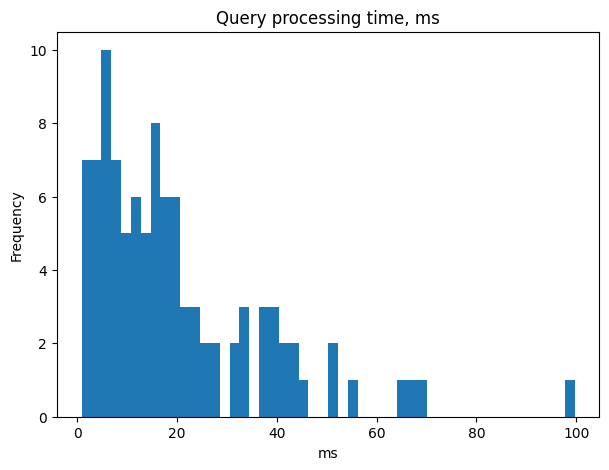

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

query_time=[]
for query_text in queries_texts[0:100]:
    qp = setup_parser(MultifieldParser(["title", "body"], schema=schema))
    q = qp.parse(query_text)
    with ix.searcher() as searcher:
        start = time.time()
        results = searcher.search(q)
        end = time.time()
        query_time.append((end-start) * 1000)
#print(query_time)

# Plot Histogram on query_time
plt.hist(query_time, bins=50)
plt.gca().set(title='Query processing time, ms', ylabel='Frequency', xlabel='ms')

Ограничим поисковые запросы по времени

In [ ]:
from whoosh.collectors import TimeLimitCollector, TimeLimit

for query_text in queries_texts_sample:
    qp = setup_parser(MultifieldParser(["title", "body"], schema=schema))
    q = qp.parse(query_text)
    with ix.searcher() as searcher:
        c = searcher.collector(limit=None)
        tlc = TimeLimitCollector(c, timelimit=0.015)
        try:
            results = searcher.search_with_collector(q, tlc)
        except TimeLimit:
            print("Search took too long, aborting!")
        # Все еще можем посмотреть частичные результаты
        output_results(tlc.results(), query_text)

Search took too long, aborting!
==== Number of results: 0 for query (1|I) 9736586783 (НАЙТИ|SEARCH|ВЗЯТЬ|ВЫЯСНИТЬ|ДОСТАТЬ|ИСКАТЬ|НАХОДИТЬ|ПОИСК|ПОЛУЧИТЬ) КОМУ (ПРИНАДЛЕЖАТЬ|ИМЕТЬ) (ЭТОТ|ETOT) (НОМЕР|КОМНАТА|НОМЕРНОЙ|НОМЕРОК)

==== Number of results: 0 for query (1|I) (MASCULINE|МАСКАЛАЙН|МАСКАЛИН|МАСКУЛАЙН) ОТЗИВ

Search took too long, aborting!
==== Number of results: 0 for query (1|I) (АНАЛИЗ|ИССЛЕДОВАНИЕ|РАЗБОР) (СОЗДАТЬ|CREATION|ВОССОЗДАТЬ|СОЗДАВАТЬ|СОЗДАВАТЬСЯ|СОЗДАНИЕ|СОЗДАТЕЛЬ|СОТВОРИТЬ|ТВОРЕНИЕ) (УСЛОВИЕ|ДОГОВОР|ДОГОВОРЕННОСТЬ|СОГЛАШЕНИЕ) ДЛЯ (РАЗВИТИЕ|РОСТ|СТАНОВЛЕНИЕ|ФОРМИРОВАНИЕ|ЭВОЛЮЦИЯ) (ИГРОВОЙ|ИГРА) (ДЕЯТЕЛЬНОСТЬ|ДЕЙСТВИЕ|ДЕЯТЕЛЬНЫЙ) (ГРУППА|ГРУППИРОВАТЬ|КОЛЛЕКТИВ) (РАННИЙ|ЗАРАНЕЕ|НАЧАЛЬНЫЙ|ПРЕЖДЕ|ПРЕЖДЕВРЕМЕННЫЙ|РАНЕЕ)

Search took too long, aborting!
==== Number of results: 15 for query (1|I) (ВИНА|VIN|VINUM|WIN) (ОФИЦИАЛЬНЫЙ|ОФИЦИАЛЬНОСТЬ) (САЙТ|SIGHT|SITE)
Docid: 345 B Title:  ПРОВЕРИТЬ ПРОБИТЬ АВТО ПО ВИНА VIN КОД БЕСПЛАТНО В ГИБДД МОЖНО НА ОФИЦИАЛЬНЫЙ САЙТ Highligh

 Вспомогательные методы **document()**, **documents()** позволяют извлекать поля на основе терминов, переданных в качестве ключевых слов.

In [ ]:
qp = setup_parser(MultifieldParser(["title", "body"], schema=schema))
q = qp.parse(query_text)
with ix.searcher() as searcher:
    print(len(list(searcher.documents(is_small=True))))
    print(searcher.document(docid=2109))

1964
{'body': ' ПРОШИВАТЬ КИТАЙСКИЙ МАГНИТОЛА С ПОМОЩЬ ПРЕДСТАВИТЬ ПОШАГОВЫЙ ИНСТРУКЦИЯ ПРОШИВКА ОСОБЕННОСТЬ ПРОШИВКА КИТАЙСКИЙ МАГНИТОЛА 4 ОЦЕНКА СРЕДНИЙ 2 75 ИЗ 5 ЗАГРУЗКА ОСОБЕННОСТЬ ПРОШИВКА КИТАЙСКИЙ МАГНИТОЛА НЕ ВСЕГДА ИСХОДНЫЙ ФУНКЦИЯ КУПИТЬ ТЕХНИК ИДЕАЛЬНЫЙ ПОДХОДИТЬ КИТАЙСКИЙ МАГНИТОЛА НЕ ИСКЛЮЧЕНИЕ ПОМОЧЬ ИХ УЛУЧШИТЬ ТАК НАЗЫВАТЬ ПЕРЕПРОШИВКА КАК И ДЛЯ ЛЮБОЙ СОВРЕМЕННЫЙ ТЕХНИК ДЛЯ НИХ ДОСТУПНЫЙ ОБНОВЛЕНИЕ ОТ ПРОИЗВОДИТЕЛЬ ЧТОБЫ ПОЛЬЗОВАТЬСЯ ДРУГОЙ МНОГО МОДНЫЙ ФУНКЦИЯ НОВЫЙ АППАРАТ ПОКУПАТЬ ЧАСТЫЙ ВСЕГО НЕ НАДО ПРОШИВКА КИТАЙСКИЙ МАГНИТОЛА 1 ЧТО ТАКОЕ ПРОШИВКА И КАК ЭТО РАБОТАТЬ 2 ЛЕГАЛЬНЫЙ НЕЛЕГАЛЬНЫЙ ИНТЕЛЛЕКТУАЛЬНЫЙ СОБСТВЕННОСТЬ 3 ГДЕ СКАЧАТЬ ОБНОВЛЕНИЕ ИЛИ ПРОШИВКА 3 КИТАЙСКИЙ АВТОМАГНИТОЛА НА АНДРОИД ЧТО ТАКОЕ ПРОШИВКА И КАК ЭТО РАБОТАТЬ ПРАКТИЧЕСКИЙ ВСЯ СОВРЕМЕННЫЙ ТЕХНИКА ОБЛАДАТЬ ЧЕМ ТО ВРОДЕ СОЗНАНИЕ ЭТО ПРОГРАММА КОТОРЫЕ ВСТРОИТЬ В ЕЕ ПАМЯТЬ ПЕРЕПРОШИВКА ЭТО ИЗМЕНЕНИЕ СОЗНАНИЕ ТЕХНИК ЕЕ ПРОГРАММА ПОРЫТЬ ВЕСЬМА ВЕСОМЫЙ ПРОШИВКА БЫВАТЬ ЛЕГАЛЬНЫЙ И НЕЛЕГАЛЬНЫЙ ЕСЛИ МО

Комбинируем несколько выдач
**Results.upgrade_and_extend(results)** - результаты, которые есть в обеих выдачах поднимаются наверх, остальные добавляются в конец

**Results.upgrade(results)** - результаты, которые есть в обеих выдачах поднимаются наверх

**Results.extend(results)** - результаты второй выдачи добавляются в конец первой

**Results.filter(results)** - убираем результаты второй выдачи из первой

In [ ]:
for query_text in queries_texts_sample:
    # Допустим, поиск по title имеет бесконечно больший вес, чем
    # по body. Мы можем установить очень большой field_boost, а можем скомбинировать
    # 2 выдачи
    qpt = setup_parser(QueryParser("title", schema=schema))
    qt = qpt.parse(query_text)

    qpb = setup_parser(QueryParser("body", schema=schema))
    qb = qpb.parse(query_text)

    with ix.searcher() as searcher:
        results = searcher.search(qt, limit=5)
        results_body = searcher.search(qb, limit=10)
        results.upgrade_and_extend(results_body)
        # Т.к. искали изначально по title, highlights (сниппеты) отсутствуют
        output_results(results, query_text)

==== Number of results: 0 for query (1|I) 9736586783 (НАЙТИ|SEARCH|ВЗЯТЬ|ВЫЯСНИТЬ|ДОСТАТЬ|ИСКАТЬ|НАХОДИТЬ|ПОИСК|ПОЛУЧИТЬ) КОМУ (ПРИНАДЛЕЖАТЬ|ИМЕТЬ) (ЭТОТ|ETOT) (НОМЕР|КОМНАТА|НОМЕРНОЙ|НОМЕРОК)

==== Number of results: 0 for query (1|I) (MASCULINE|МАСКАЛАЙН|МАСКАЛИН|МАСКУЛАЙН) ОТЗИВ

==== Number of results: 0 for query (1|I) (АНАЛИЗ|ИССЛЕДОВАНИЕ|РАЗБОР) (СОЗДАТЬ|CREATION|ВОССОЗДАТЬ|СОЗДАВАТЬ|СОЗДАВАТЬСЯ|СОЗДАНИЕ|СОЗДАТЕЛЬ|СОТВОРИТЬ|ТВОРЕНИЕ) (УСЛОВИЕ|ДОГОВОР|ДОГОВОРЕННОСТЬ|СОГЛАШЕНИЕ) ДЛЯ (РАЗВИТИЕ|РОСТ|СТАНОВЛЕНИЕ|ФОРМИРОВАНИЕ|ЭВОЛЮЦИЯ) (ИГРОВОЙ|ИГРА) (ДЕЯТЕЛЬНОСТЬ|ДЕЙСТВИЕ|ДЕЯТЕЛЬНЫЙ) (ГРУППА|ГРУППИРОВАТЬ|КОЛЛЕКТИВ) (РАННИЙ|ЗАРАНЕЕ|НАЧАЛЬНЫЙ|ПРЕЖДЕ|ПРЕЖДЕВРЕМЕННЫЙ|РАНЕЕ)
Docid: 297 B Title:  ПЕДАГОГИЧЕСКИЙ УСЛОВИЕ ФОРМИРОВАНИЕ ИГРОВОЙ ДЕЯТЕЛЬНОСТЬ РЕБЕНОК РАННИЙ ВОЗРАСТ Highlights: 
Docid: 303 B Title:  ДЛЯ ПЕДАГОГ ПЕДАГОГИЧЕСКИЙ УСЛОВИЕ РАЗВИТИЕ РЕБЕНОК РАННИЙ ВОЗРАСТ Highlights: 
Docid: 307 B Title:  СОЗДАНИЕ УСЛОВИЕ ДЛЯ СЕНСОРНЫЙ РАЗВИТИЕ РЕБЕНОК РАННИЙ ВОЗРАСТ Highlights: 
Docid: 

## Разбор пользовательских запросов

По-умолчанию пробел между словами разбирается как конъюнкция, мы можем изменить это:

In [ ]:
from whoosh import qparser

parser = qparser.QueryParser("body", schema=schema,
                             group=qparser.OrGroup)
query_text = queries_texts_sample[0]
print(query_text)
print(parser.parse(query_text))

(1|I) 9736586783 (НАЙТИ|SEARCH|ВЗЯТЬ|ВЫЯСНИТЬ|ДОСТАТЬ|ИСКАТЬ|НАХОДИТЬ|ПОИСК|ПОЛУЧИТЬ) КОМУ (ПРИНАДЛЕЖАТЬ|ИМЕТЬ) (ЭТОТ|ETOT) (НОМЕР|КОМНАТА|НОМЕРНОЙ|НОМЕРОК)
(body:9736586783 OR body:найти OR body:search OR body:взять OR body:выяснить OR body:достать OR body:искать OR body:находить OR body:поиск OR body:получить OR body:кому OR body:принадлежать OR body:иметь OR body:этот OR body:etot OR body:номер OR body:комната OR body:номерной OR body:номерок)


Такая интерпретация запросов для запроса **foo bar** будет давать документу, содержащему 4 раза **foo** больший вес, чем документу в котором есть и **foo**, и **bar** . Чтобы исправить ситуацию, можем указывать параметр, дающий больший вес документам, которые содержат больше разных слов:

In [ ]:
og = qparser.OrGroup.factory(0.9)
parser = qparser.QueryParser("body", schema, group=og)

Как видели чуть выше, QueryParser преобразует запросы по одному полю (body)в запросы такого вида:
body:foo body:bar. Можем отключить это.

In [ ]:
parser = qparser.QueryParser("body", schema=schema)
parser.remove_plugin_class(qparser.FieldsPlugin)

# Можем также отключить поддержку wildcards
parser.remove_plugin_class(qparser.WildcardPlugin)

Обрабатываем нечеткие (fuzzy) запросы - с опечатками, т.е. имеющими определенное расстояние Дамерау-Левенштейна, т.е. количество операций вставки, удаления, замены и транспозиции (перестановки двух соседних символов).

In [ ]:
qp = qparser.QueryParser("body", schema)
qp.add_plugin(qparser.FuzzyTermPlugin())

# Ищем только по body
query_text = qp.parse("вес~")
with ix.searcher() as searcher:
    # По-умолчанию results содержит первые 10 документов соответствующих запросу
    results = searcher.search(query_text)
    output_results(results, query_text)

==== Number of results: 1186 for query body:вес~
Docid: 10 S Title:  RAIM FEAT ARTUR ADIL ДОМ СКАЧАТЬ РИНГТОН НА ЗВОНОК ТЕЛЕФОН Highlights: САЙТ СПЕЦИАЛЬНЫЙ ДЛЯ <b class="match term0">ВАС</b> ЭТО НЕ ПРОСТО ПЕСНЯ МЕЛОДИЯ...ЖЕЛАНИЕ И ТОЛЬКО ДЛЯ <b class="match term0">ВАС</b>
Docid: 12 S Title:  RAIM FEAT ARTUR ADIL ДОМ YOUTUBE Highlights: СЛЫШАТЬ НОВОСТЬ <b class="match term1">ВЕБ</b> ВЕРСИЯ YOUTUBE MUSIC
Docid: 19 S Title:  ЗАПЧАСТЬ ДЛЯ ИНОМАРКА ОРИГИНАЛ И АНАЛОГ КУПИТЬ ПО НИЗКА ЦЕНА Highlights: МЫ МОЖЕМ ЗАВЕРИТЬ <b class="match term0">ВАС</b> ЧТО В НАШЕМ МАГАЗИН ВЫ...AUTOCOMPA ПРЕДЛАГАТЬ <b class="match term2">ВЕСЬ</b> АССОРТИМЕНТ ПО ЗНАЧИТЕЛЬНЫЙ
Docid: 22 S Title:  КАЛЬКУЛЯТОР ОНЛАЙН РЕШЕНИЕ ПОКАЗАТЕЛЬНЫЙ УРАВНЕНИЕ Highlights: РАБОТАТЬ ВОЗМОЖНО У <b class="match term0">ВАС</b> ВКЛЮЧИТЬ ADBLOCK В ЭТОМ...ОБНОВИТЬ СТРАНИЦА У <b class="match term0">ВАС</b> В БРАУЗЕР ОТКЛЮЧИТЬ
Docid: 24 B Title:  ПРИВЕДЕНИЕ ВПОРЯДОК ВПУСК A4 B6 1 8Т AMB ИЛИ ПОБЕГ С ОВОЩНОЙ БАЗ AUDI CLUB RUSSIA Highlights: 

Теперь мы можем обрабатывать такие запросы:

`ВЕС~`

добавление ~ говорит о том, что данный термин нечеткий, можно указывать также расстояние, по-умолчанию 1.
Такой запрос найдет нам документы, содержащие ВЕСЬ (добавление Ь), ВАС (замена Е на А) и ВСЕ (перестановка Е и С)

`ВЕС~2`

Здесь смотрим уже на расстояние 2. Расстояние больше чем 2 может обрабатываться очень долго.

## Задание 2

Давайте полностью перестроим индекс, разобъем исходную коллекцию на 3 корзинки по размеру: до 3 кб, от 3 до 10 кб и более 10 кб.
Пройдем по 5 запросам из исходных, по каждому запросу в выдачу включим не более 3 документов из каждой корзинки.

# Вопросы?